In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector 
from tensorflow.keras.layers import TimeDistributed,Flatten

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = 'drive/MyDrive/Colab Notebooks/b2.csv'
raw_data = pd.read_csv(file, parse_dates = ['date'], index_col = 'date')

df = raw_data.copy()
print(df.head())

            PM2dot5    PM10     NO    NO2    NOx    NH3    SO2    CO  Ozone  \
date                                                                          
2019-01-01   151.12  515.67  56.88  54.95  75.44  74.42  18.54  2.51  27.43   
2019-01-02   257.21  625.60  58.90  73.14  86.91  81.71  21.16  3.00  31.07   
2019-01-03   141.07  515.14  22.73  44.50  42.12  75.25  16.18  2.02  17.08   
2019-01-04   222.49  383.30  18.52  36.10  34.29  53.20  15.61  1.88  12.88   
2019-01-05   309.92  494.91  18.40  58.23  45.92  49.80  15.43  2.10   3.63   

            Wind speed  
date                    
2019-01-01        0.64  
2019-01-02        0.84  
2019-01-03        0.97  
2019-01-04        0.80  
2019-01-05        1.33  


In [ ]:
df.describe()

,PM2dot5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
count,1026.000000,996.000000,1028.000000,1028.000000,1028.000000,1032.000000,1016.000000,1025.000000,1026.000000,365.000000
mean,118.970955,229.700748,9.980272,32.364110,26.534018,36.012524,11.248100,1.164990,38.311676,1.177671
std,94.117334,138.305529,13.281891,22.964907,19.223764,18.258039,7.584875,0.652307,22.022606,0.407871
min,13.450000,12.040000,0.450000,1.840000,3.660000,0.040000,1.260000,0.190000,3.500000,0.500000
25%,51.985000,119.867500,2.287500,16.027500,12.647500,23.152500,5.365000,0.730000,21.580000,0.900000
50%,87.720000,204.040000,4.480000,27.520000,20.095000,31.970000,8.980000,1.020000,33.110000,1.110000
75%,160.025000,311.057500,11.387500,42.680000,34.560000,44.295000,16.000000,1.460000,52.045000,1.390000
max,703.000000,810.940000,89.760000,188.580000,123.310000,121.590000,39.640000,5.900000,114.590000,3.030000


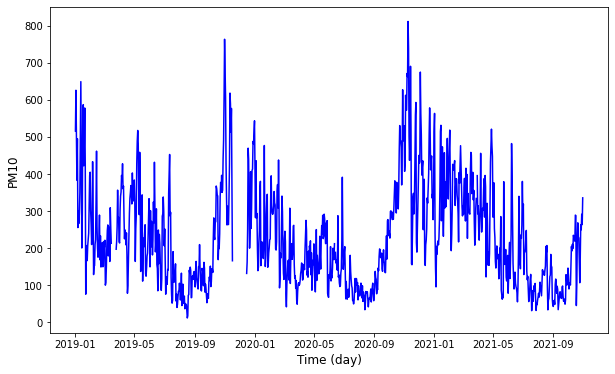

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['PM10'], 'Time (day)', 'PM10')


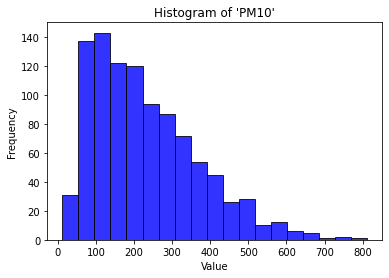

In [ ]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'blue', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['PM10'])

In [ ]:
#RENAME
#df = df.rename(columns = {'Max Temp (C)':'Max_T', 'Min Temp (C)':'Min_T','Total Precip (mm)':'T_P','WC (m3/capita.day)':'UWC'})

# Missing values
df.isnull().sum()

PM2dot5         9
PM10           39
NO              7
NO2             7
NOx             7
NH3             3
SO2            19
CO             10
Ozone           9
Wind speed    670
dtype: int64

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['PM2dot5'])
replace_missing(df['PM10'])
replace_missing(df['NO'])
replace_missing(df['NO2'])
replace_missing(df['NOx'])
replace_missing(df['NH3'])
replace_missing(df['SO2'])
replace_missing(df['CO'])
replace_missing(df['Ozone'])
replace_missing(df['Wind speed'])

#replace_missing(df['Humidity'])
#replace_missing(df['Temp'])

In [ ]:
# Outlier detection
up_b = df['PM10'].mean() + 2*df['PM10'].std()
low_b = df['PM10'].mean() - 2*df['PM10'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['PM10'] > up_b, 'PM10'] = np.nan
df.loc[df['PM10'] < low_b, 'PM10'] = np.nan
df['PM10'].interpolate(inplace=True)

Dimension of train data:  (828, 10)
Dimension of test data:  (207, 10)


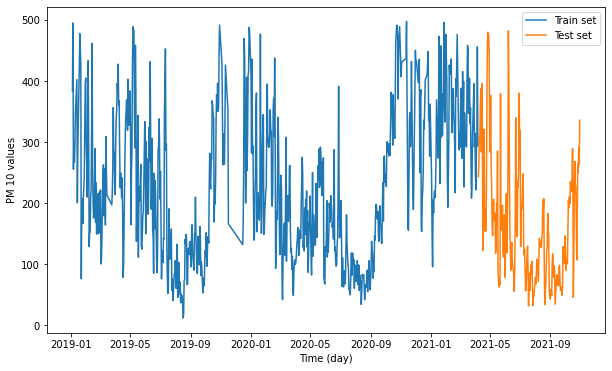

In [ ]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.PM10)
plt.plot(test_dataset.PM10)
plt.xlabel('Time (day)')
plt.ylabel('PM 10 values')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [ ]:
X_train = train_dataset.drop('PM10', axis = 1)
y_train = train_dataset.loc[:,['PM10']]

X_valid = test_dataset.drop('PM10', axis = 1)
y_valid = test_dataset.loc[:,['PM10']]

In [ ]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
valid_y_norm = output_scaler.transform(y_valid)
valid_x_norm = input_scaler.transform(X_valid)

In [ ]:
def create_dataset (X, Y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(Y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_valid, Y_valid = create_dataset(valid_x_norm, valid_y_norm, TIME_STEPS)
X_train, Y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_valid.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_valid.shape: ', X_valid.shape) 
print('Y_valid.shape: ', Y_train.shape)

X_train.shape:  (177, 30, 9)
Y_train.shape:  (798, 1)
X_valid.shape:  (177, 30, 9)
Y_valid.shape:  (798, 1)


### Train/validation split

### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)


In [ ]:
mlp_history = model_mlp.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
25/25 - 1s - loss: 0.1336 - val_loss: 0.0400 - 1s/epoch - 55ms/step
Epoch 2/40
25/25 - 0s - loss: 0.0768 - val_loss: 0.0288 - 158ms/epoch - 6ms/step
Epoch 3/40
25/25 - 0s - loss: 0.0603 - val_loss: 0.0273 - 223ms/epoch - 9ms/step
Epoch 4/40
25/25 - 0s - loss: 0.0577 - val_loss: 0.0269 - 256ms/epoch - 10ms/step
Epoch 5/40
25/25 - 0s - loss: 0.0560 - val_loss: 0.0266 - 316ms/epoch - 13ms/step
Epoch 6/40
25/25 - 0s - loss: 0.0544 - val_loss: 0.0265 - 278ms/epoch - 11ms/step
Epoch 7/40
25/25 - 0s - loss: 0.0531 - val_loss: 0.0264 - 290ms/epoch - 12ms/step
Epoch 8/40
25/25 - 0s - loss: 0.0519 - val_loss: 0.0262 - 284ms/epoch - 11ms/step
Epoch 9/40
25/25 - 0s - loss: 0.0508 - val_loss: 0.0262 - 225ms/epoch - 9ms/step
Epoch 10/40
25/25 - 0s - loss: 0.0500 - val_loss: 0.0262 - 279ms/epoch - 11ms/step
Epoch 11/40
25/25 - 0s - loss: 0.0492 - val_loss: 0.0261 - 213ms/epoch - 9ms/step
Epoch 12/40
25/25 - 0s - loss: 0.0485 - val_loss: 0.0260 - 332ms/epoch - 13ms/step
Epoch 13/40
25/25 - 

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
X_train_series = X_train.reshape(798,30,9)
X_valid_series = X_valid.reshape(177,30,9)
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (798, 30, 9)
Validation set shape (177, 30, 9)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_x_norm.shape[1], train_x_norm.shape[1])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
25/25 - 3s - loss: 0.1247 - val_loss: 0.0304 - 3s/epoch - 107ms/step
Epoch 2/40
25/25 - 0s - loss: 0.0467 - val_loss: 0.0267 - 309ms/epoch - 12ms/step
Epoch 3/40
25/25 - 0s - loss: 0.0387 - val_loss: 0.0249 - 362ms/epoch - 14ms/step
Epoch 4/40
25/25 - 0s - loss: 0.0351 - val_loss: 0.0245 - 399ms/epoch - 16ms/step
Epoch 5/40
25/25 - 0s - loss: 0.0332 - val_loss: 0.0233 - 389ms/epoch - 16ms/step
Epoch 6/40
25/25 - 0s - loss: 0.0315 - val_loss: 0.0237 - 309ms/epoch - 12ms/step
Epoch 7/40
25/25 - 0s - loss: 0.0299 - val_loss: 0.0246 - 239ms/epoch - 10ms/step
Epoch 8/40
25/25 - 0s - loss: 0.0285 - val_loss: 0.0233 - 421ms/epoch - 17ms/step
Epoch 9/40
25/25 - 0s - loss: 0.0271 - val_loss: 0.0236 - 334ms/epoch - 13ms/step
Epoch 10/40
25/25 - 0s - loss: 0.0255 - val_loss: 0.0235 - 330ms/epoch - 13ms/step
Epoch 11/40
25/25 - 0s - loss: 0.0249 - val_loss: 0.0237 - 438ms/epoch - 18ms/step
Epoch 12/40
25/25 - 0s - loss: 0.0252 - val_loss: 0.0238 - 444ms/epoch - 18ms/step
Epoch 13/40
25/

### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
#model_lstm.summary()

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
25/25 - 5s - loss: 0.1374 - val_loss: 0.0308 - 5s/epoch - 203ms/step
Epoch 2/40
25/25 - 1s - loss: 0.0455 - val_loss: 0.0238 - 846ms/epoch - 34ms/step
Epoch 3/40
25/25 - 1s - loss: 0.0412 - val_loss: 0.0234 - 852ms/epoch - 34ms/step
Epoch 4/40
25/25 - 1s - loss: 0.0394 - val_loss: 0.0244 - 872ms/epoch - 35ms/step
Epoch 5/40
25/25 - 1s - loss: 0.0380 - val_loss: 0.0231 - 849ms/epoch - 34ms/step
Epoch 6/40
25/25 - 1s - loss: 0.0366 - val_loss: 0.0229 - 1s/epoch - 41ms/step
Epoch 7/40
25/25 - 1s - loss: 0.0348 - val_loss: 0.0229 - 967ms/epoch - 39ms/step
Epoch 8/40
25/25 - 1s - loss: 0.0347 - val_loss: 0.0231 - 849ms/epoch - 34ms/step
Epoch 9/40
25/25 - 1s - loss: 0.0327 - val_loss: 0.0231 - 867ms/epoch - 35ms/step
Epoch 10/40
25/25 - 1s - loss: 0.0319 - val_loss: 0.0219 - 835ms/epoch - 33ms/step
Epoch 11/40
25/25 - 1s - loss: 0.0313 - val_loss: 0.0242 - 839ms/epoch - 34ms/step
Epoch 12/40
25/25 - 1s - loss: 0.0313 - val_loss: 0.0237 - 836ms/epoch - 33ms/step
Epoch 13/40
25/25 

### CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
X_train_series_sub = X_train_series.reshape((798,2,135,1))
X_valid_series_sub = X_valid_series.reshape((177,2,135,1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (798, 2, 135, 1)
Validation set shape (177, 2, 135, 1)


In [ ]:
model_cnn_lstm = Sequential()

import tensorflow as tf
tf.keras.layers.TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

ValueError: ignored

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

### Comparing models

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

#### CNN on train and validation

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

#### LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

#### CNN-LSTM on train and validation

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))